In [1]:
from DataProcessing import Data
import tensorflow as tf
from tensorflow import keras as keras

# 1. Get Data

## 1.1. Get data from folder

In [2]:
d = Data()
d.get_index_names()

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']


['AAPL',
 'ORCL',
 'GOOGL',
 'AMZN',
 'BK',
 'LIFE',
 'T',
 'XOM',
 'VHM',
 'CTR',
 'FPT',
 'MBB']

In [3]:
chosen_index = 'VHM'
d.preprocess(chosen_index)
df = d.get_data(chosen_index).drop(['Date','Volume'],axis=1)
df.columns

Processing VHM.csv


e:\BK-nam3\ky2\ML\project\DataProcessing.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  rsi.append(100-100/(1+gain/-loss))
e:\BK-nam3\ky2\ML\project\DataProcessing.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  mfi.append(100-(100/(1+pos/neg)))


Saved VHM data at data/processed/VHM.csv


Index(['Open', 'High', 'Low', 'Close', 'RSI', 'MFI', 'EMA', 'SO', 'MACD',
       'Next Day Price'],
      dtype='object')

In [4]:
df.shape


(728, 10)

In [5]:
X = df[df.columns[0:8]].values
Y = df[df.columns[8]].values

TRAIN_PERCENT = 0.7
train_size = int(TRAIN_PERCENT*len(X))

X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(Y)]

## 1.2. Scale data

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Train model

In [7]:
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.LSTM(100,input_shape=(None,8),return_sequences=True,activation='relu'))
rnn_model.add(keras.layers.Dense(1))
rnn_model.summary()

e:\BK-nam3\ky2\ML\project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 100)      │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 1)        │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,701 (170.71 KB)

 Trainable params: 43,701 (170.71 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [9]:
num_epochs = 1
# TODO looks worse on plot and error higher when increase batch size, but test converges 
batch_size = 8
learning_rate = 0.001
Adam = keras.optimizers.Adam(learning_rate)
MSE = keras.losses.MeanSquaredError()

## 2.1. Train

In [10]:
rnn_model.compile(optimizer=Adam,loss=MSE)
history = rnn_model.fit(X_train,Y_train,epochs=num_epochs,validation_data=(X_test,Y_test),batch_size=batch_size)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7208431616.0000 - val_loss: 9024021504.0000


## 2.2. Test

In [11]:
Y_pred = rnn_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [12]:
Y_pred.shape

(219, 1, 1)

In [13]:
Y_pred = Y_pred.reshape(219)

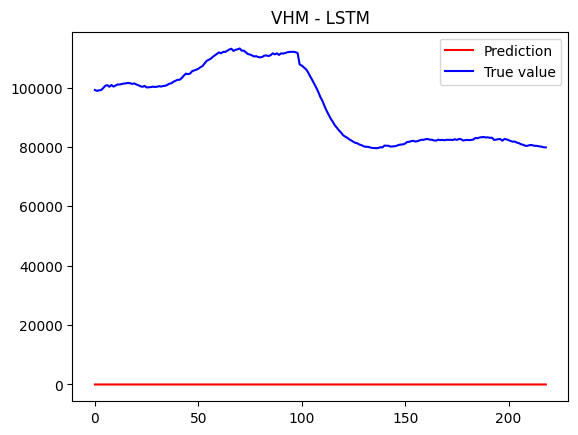

In [14]:
import matplotlib.pyplot as plt
plt.plot(Y_pred,c='red',label = 'Prediction')
plt.plot(Y_test,c='blue',label = 'True value')
plt.legend(loc='upper right')
plt.title(f'{chosen_index} - LSTM')
plt.show()

## 2.3. Evaluate

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 9024019632.695131
Mean Absolute Error: 94176.22454282761
R-squared: -57.268954263162684


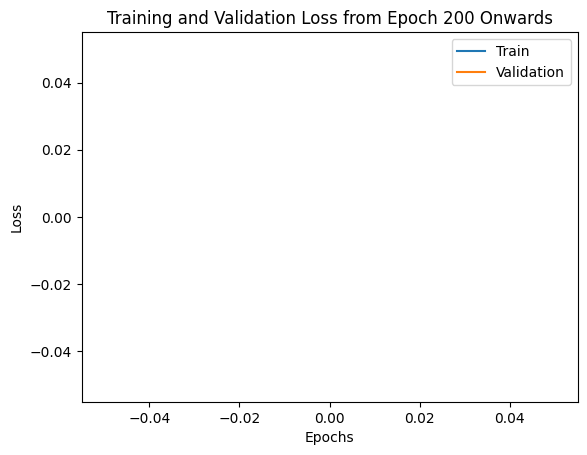

In [16]:
# Plot convergence starting from epoch 200
plt.plot(range(200, len(history.history['loss'])), history.history['loss'][200:], label='Train')
plt.plot(range(200, len(history.history['val_loss'])), history.history['val_loss'][200:], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss from Epoch 200 Onwards')
plt.legend()
plt.show()


## Save results

In [20]:
import time
from helper import calculate_loss, prepare_data
import numpy as np

mae = []
mse = []
r2 = []
rmse = []
mape = []
avg_runtime = 0

list_tickers = d.get_sp500_tickers()
# track run time

for ticker in list_tickers:
    start = time.time()
    X_train, Y_train, X_test, Y_test = prepare_data(ticker)

    # call model
    rnn_model = keras.Sequential()
    rnn_model.add(keras.layers.LSTM(100,input_shape=(None,8),return_sequences=True,activation='relu'))
    rnn_model.add(keras.layers.Dense(1))
    rnn_model.summary()
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
    rnn_model.compile(optimizer=Adam,loss=MSE)
    history = rnn_model.fit(X_train,Y_train,epochs=num_epochs,validation_data=(X_test,Y_test),batch_size=batch_size)    

    # predictions = model.predict(X_test)
    mse_, r2_, rmse_, mape_, mae_ = calculate_loss(rnn_model, X_test, Y_test)
    mae.append(mae_)
    mse.append(mse_)
    r2.append(r2_)
    rmse.append(rmse_)
    mape.append(mape_)

    end = time.time()
    avg_runtime += (end-start)

mae = np.mean(list(mae))
mse = np.mean(list(mse))
r2 = np.mean(list(r2))
rmse = np.mean(list(rmse))
mape = np.mean(list(mape))
avg_runtime = avg_runtime/len(list_tickers)

with open('output/evaluation.csv', 'a') as f:
    f.write(f'LSTM,{mae},{mse},{r2},{rmse},{mape},{avg_runtime}\n')

X_train: (996, 8), Y_train: (996,), X_test: (249, 8), Y_test: (249,)


e:\BK-nam3\ky2\ML\project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, None, 100)      │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 1)        │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,701 (170.71 KB)

 Trainable params: 43,701 (170.71 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).